#Plant Disease Classification

**Dataset** :
[plant-pathology-2020-fgvc7](https://www.kaggle.com/c/plant-pathology-2020-fgvc7)

**Objectives** : 
1. Classify a given image from testing dataset into different diseased category or a healthy leaf.
2. Distinguish between many diseases, sometimes more than one on a single leaf.
3. Deal with rare classes and novel symptoms.
4. Address depth perception—angle, light, shade, physiological age of the leaf.
5. Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import os
import numpy as np
import pandas as pd
import shutil
import random
import cv2
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.util import random_noise
import  matplotlib.pyplot as plt
from sklearn import metrics
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,Dense,BatchNormalization,Dropout,Flatten,MaxPooling2D
from keras.regularizers import l2
from keras.callbacks.callbacks import EarlyStopping
from keras.callbacks.callbacks import ModelCheckpoint

Using TensorFlow backend.


###Mount Google Drive

Initially we mount the google drive, to be able to access the dataset. Dataset is uploaded on Google drive to achieve ease in accessiblity.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

###Load & Extract dataset

Zipped file is uploaded at location '/My Drive/plant-pathology-2020-fgvc7.zip'. Which is loaded and unzipped for use on colab platform.  

Extracted Zip file cotains 3 files:
1. Images folder - contains all train/test images 
2. Train.csv - inforamtion of training image id's and class of images present in 'Image' folder.
3. Test.csv - information of test image id's

In [0]:
import os
import zipfile

BASE_PATH = '/content'

def extract_dataset(path):
  #Extracting the dataset from the zip file

  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(BASE_PATH)
  zip_ref.close()


In [0]:
extract_dataset('/content/drive/My Drive/plant-pathology-2020-fgvc7.zip')

##Data Pre-processing

To start with data pre-processing steps, initially distribute training images to its designated classes {healthy, multiple_diseases, rust, scab}. 

In [0]:
data_df = pd.read_csv('train.csv')
data_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [0]:
len(data_df) #Number of training images in dataset

1821

### Sampling of the images and splitting into Test and Train.
1. A bar chart is plotted to check the distribution of images for the different classes.
2. Here the images will be extracted from the source folder and the images of therespective classes will be stored in the class directory created programmaticaly as the code executes.

3. Next, 20 % of the images in each classes will be fetched and stored in the Test directory and a new dataframe test_df will be created to store the labels.

4. For the training set the similar step will be followed as mentioned in step 3.

In [0]:
if not os.path.exists('Image_Data'):
  os.mkdir('Image_Data')
  
colnames = list(data_df.columns)
colnames.pop(0)
for item in colnames:
  if not os.path.exists('Image_Data/'+item):
    os.mkdir('Image_Data/'+item)

!ls /content/Image_Data

healthy  multiple_diseases  rust  scab


In [0]:
for i in range(len(data_df)):
  if data_df.at[i,'healthy'] == 1:
    image_name = data_df.at[i,'image_id']+'.jpg'
    shutil.copy2('images/'+image_name,'Image_Data/healthy')
  elif data_df.at[i,'multiple_diseases'] == 1:
    image_name = data_df.at[i,'image_id']+'.jpg'
    shutil.copy2('images/'+image_name,'Image_Data/multiple_diseases')
  elif data_df.at[i,'rust'] == 1:
    image_name = data_df.at[i,'image_id']+'.jpg'
    shutil.copy2('images/'+image_name,'Image_Data/rust')
  else:
    image_name = data_df.at[i,'image_id']+'.jpg'
    shutil.copy2('images/'+image_name,'Image_Data/scab')

###Bar-plot is plotted to visualise the impbalance of distribution in data for various classes

[516, 91, 622, 592]


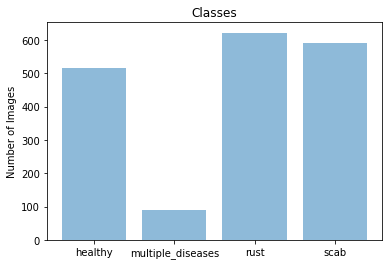

In [0]:
#distribution of images across differect class
healthy_no = len(os.listdir('Image_Data/healthy'))
multiple_diseases_no = len(os.listdir('Image_Data/multiple_diseases'))
rust_no = len(os.listdir('Image_Data/rust'))
scab_no = len(os.listdir('Image_Data/scab'))

classes = ('healthy', 'multiple_diseases', 'rust', 'scab')
y_pos = np.arange(len(classes))
count = [healthy_no,multiple_diseases_no,rust_no,scab_no]
print(count)
plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('Number of Images')
plt.title('Classes')

plt.show()

###Split image data into train & test set 

In [0]:
os.mkdir('Train')
os.mkdir('Test')

In [0]:
class_dir_list = os.listdir('Image_Data/')
column_names = ['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']
train_df = pd.DataFrame(columns = column_names)
test_df = pd.DataFrame(columns = column_names)
split_ratio = 0.20

#######Testing Set
for sub_folder in class_dir_list:
  list_sub_dir = os.listdir('Image_Data/'+sub_folder)
  len_list_sub_dir = len(list_sub_dir)
  #print(len_list_sub_dir)
  split_index = int(len_list_sub_dir*split_ratio)
  #print(sub_folder+":" +str(split_index))
  test_list = random.sample(list_sub_dir,split_index)
  #print(val_list)
  for f in test_list:
    shutil.move('Image_Data/'+sub_folder+'/'+f,'Test/'+f)
    info = data_df[data_df['image_id'] == f.split('.')[0]]
    test_df = test_df.append(info)


###### Training Set
for sub_folder in class_dir_list:
  list_sub_dir = os.listdir('Image_Data/'+sub_folder)
  #print(list_sub_dir)
  for f in list_sub_dir:
    shutil.move('Image_Data/'+sub_folder+'/'+f,'Train/'+f)
    info = data_df[data_df['image_id'] == f.split('.')[0]]
    train_df = train_df.append(info)


train_df['image_id'] = train_df['image_id']+'.jpg'
test_df['image_id'] = test_df['image_id']+'.jpg'

In [0]:
print("Training image size: ",len(train_df))
print("Test image size: ",len(test_df))

Training image size:  1458
Test image size:  363


###Image Augmentation using keras ImageDataGenerator
1. The training set will be again split in for the validation set in the ratio of 65:35.
2. Two Image Data Generator objects will be created. One for the training set with all the augmentation techniques enlisted and the second one for the testing and the validation set.


In [0]:
train, val = train_test_split(train_df, test_size = 0.35)

#ImageDataGenerator
image_size = 150

dataGenerator = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=45,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=.1,
                                fill_mode='nearest',
                                shear_range=0.1,
                                rescale=1/255,
                                )#validation_split=0.2

test_Data_Generator = ImageDataGenerator(rescale=1/255)                                
trainGenerator = dataGenerator.flow_from_dataframe(train,
                                        directory='Train/',
                                        target_size=(image_size, image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        subset='training',
                                        batch_size=32)
validGenerator =  test_Data_Generator.flow_from_dataframe(val,
                                        directory='Train/',
                                        target_size=(image_size,image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)

test_gen = test_Data_Generator.flow_from_dataframe(test_df,
                                        directory='Test/',
                                        target_size=(image_size,image_size),
                                        x_col="image_id",
                                        y_col=['healthy','multiple_diseases','rust','scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)


Found 947 validated image filenames.
Found 511 validated image filenames.
Found 363 validated image filenames.


Augmented image plot

In [0]:
def plotImages(array_of_images):
    # We define a plot of 2 rows and 4 columns of images
    fig, axes = plt.subplots(4, 4, figsize=(20,20))
    # iterate over each image and (row,col)
    for img, ax in zip( array_of_images, axes.flat):
        # show the image on the right axis
        ax.imshow(img)
        ax.axis('on')
    plt.tight_layout()
    plt.show()

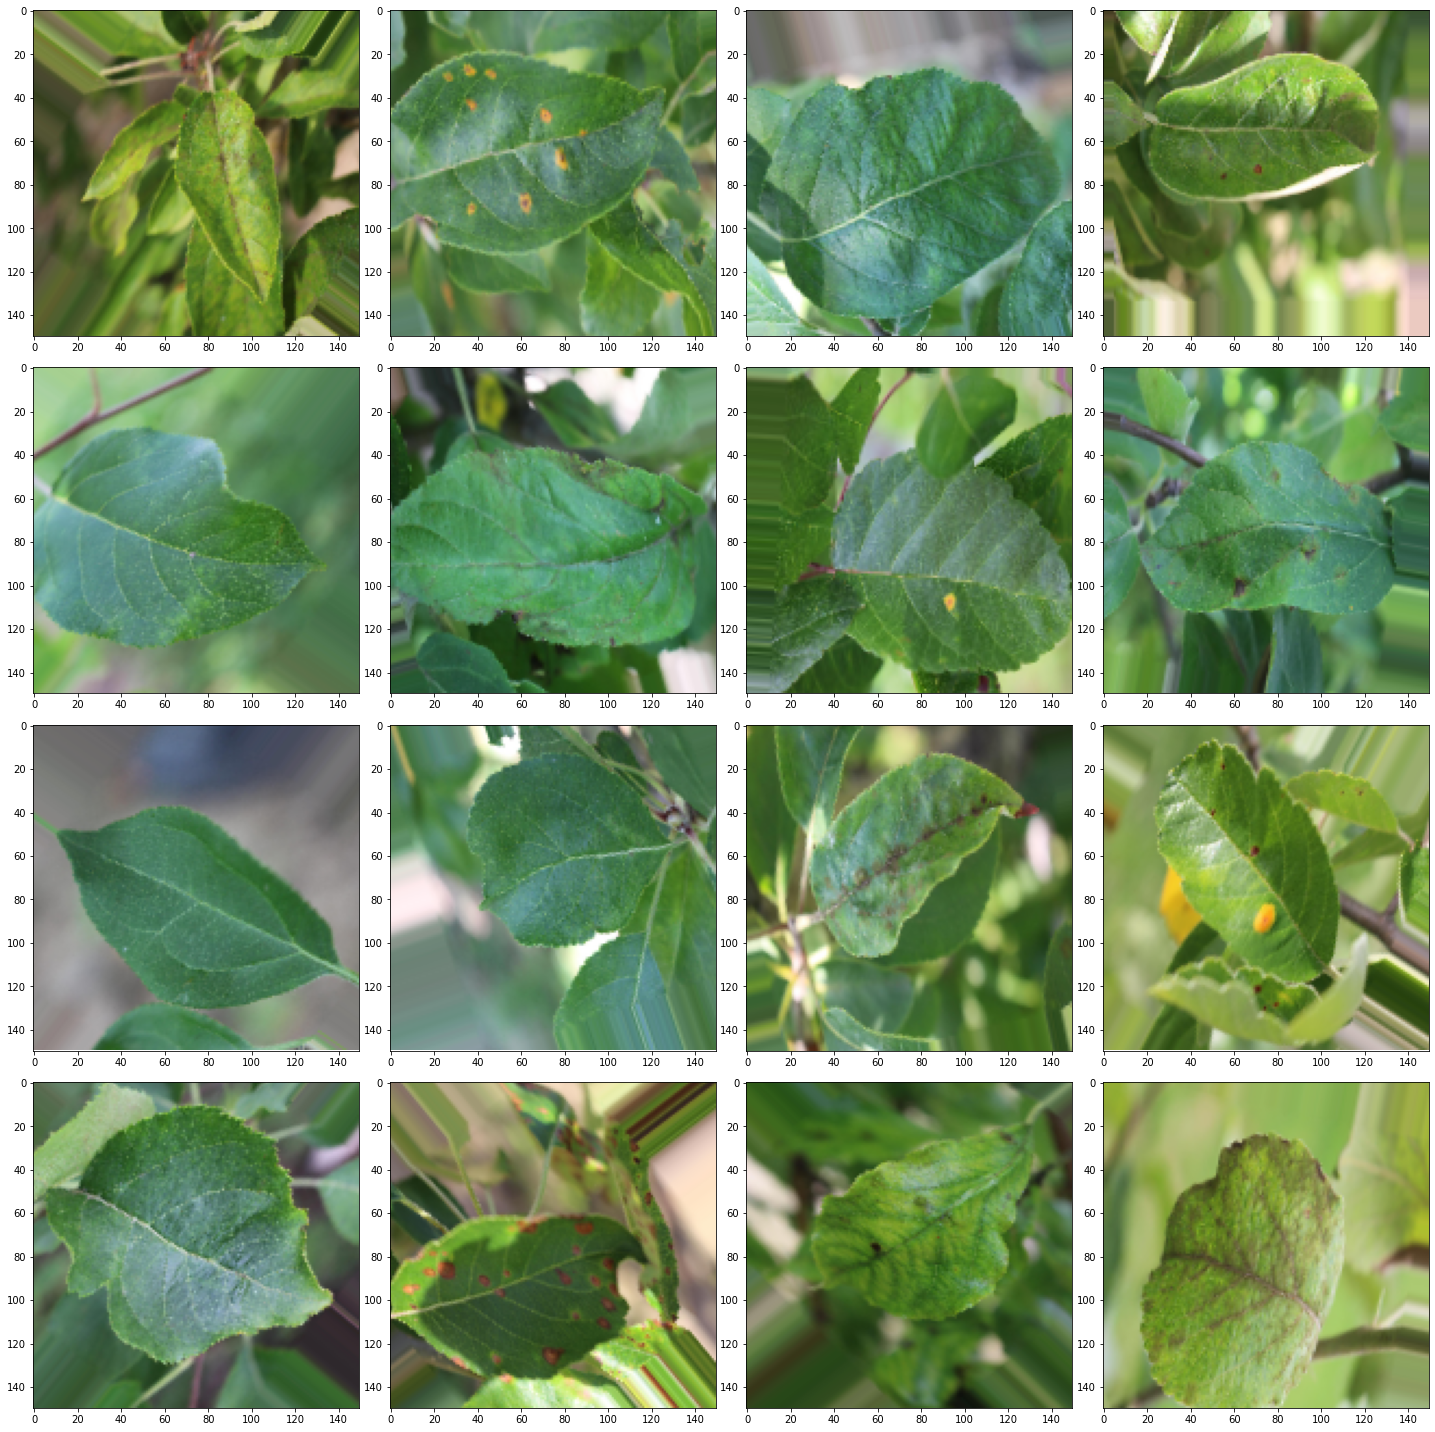

In [0]:
batch_images, _ =next(trainGenerator)

plotImages(batch_images[:16])

##Modeling 

After testing various structural combinations of layers and hyperparametrs, adopted state of art delivers model with best performance. In order to improve performance regularisation using Dropout layers are added and activation fuction Relu and Softmax are used in the structured model.

In [0]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='SAME',input_shape=(image_size,image_size,3),activation='relu'))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2000))
model.add(Dropout(0.5))
model.add(Dense(500))

model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)       

Gardiant descent technique, Adam is used for Loss optimazation with learning rate of 0.001, for  loss function 'categorical_crossentropy'. 

Evaluation metrics 'categorical_accuracy' is selected.

In [0]:
adam = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999, epsilon=1e-06, decay=0.0
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['categorical_accuracy'])

Early stop function is assigned to training function to monitor the training rate and prevent overfitting. Model checkpoint saves model at every stage of improvement to deliver best perfoming model as resultant. 

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('./drive/My Drive/best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

###Train Model

In [0]:
train_step = trainGenerator.n//trainGenerator.batch_size
val_step = validGenerator.n//validGenerator.batch_size
history = model.fit_generator(generator=trainGenerator,
                                steps_per_epoch=train_step,
                                validation_data=validGenerator,
                                validation_steps=val_step,
                                epochs=200,callbacks=[es, mc])

Epoch 1/200
29/29 [==============================] - 46s 2s/step - loss: 15.1804 - categorical_accuracy: 0.2951 - val_loss: 12.2028 - val_categorical_accuracy: 0.3333

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33333, saving model to ./drive/My Drive/best_model.h5
Epoch 2/200
29/29 [==============================] - 53s 2s/step - loss: 8.2139 - categorical_accuracy: 0.2984 - val_loss: 31.5235 - val_categorical_accuracy: 0.2401

Epoch 00002: val_categorical_accuracy did not improve from 0.33333
Epoch 3/200
29/29 [==============================] - 51s 2s/step - loss: 4.8037 - categorical_accuracy: 0.2852 - val_loss: 5.1311 - val_categorical_accuracy: 0.2714

Epoch 00003: val_categorical_accuracy did not improve from 0.33333
Epoch 4/200
29/29 [==============================] - 48s 2s/step - loss: 3.0767 - categorical_accuracy: 0.3180 - val_loss: 1.5820 - val_categorical_accuracy: 0.2004

Epoch 00004: val_categorical_accuracy did not improve from 0.33333
Epoch 5/200
29/2

###Save model

Save the training history in drive for later use in testing and evaluation.

In [0]:
hist = pd.DataFrame(history.history)
hist.to_csv('./drive/My Drive/history_2.csv')
hist.head()

val_loss  val_categorical_accuracy       loss  categorical_accuracy
0   9.645329                  0.289583  14.380852              0.310383
1  13.577423                  0.050104   5.020453              0.295082
2   1.576083                  0.308977   5.201550              0.291803
3   4.750881                  0.281837   3.328599              0.308190
4   2.205167                  0.292276   2.231187              0.308204

###Losses and Accuracy curves

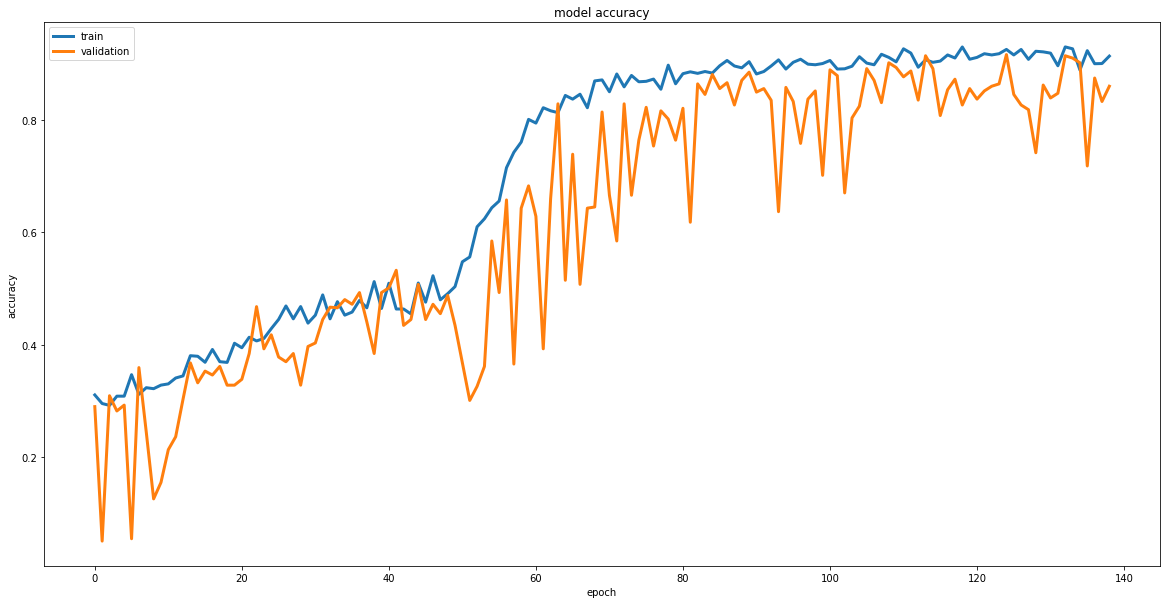

In [0]:
plt.figure(figsize=(20,10))
plt.plot(history.history['categorical_accuracy'],linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Train and validation accuracy are pretty close and following each other. Thus, we’re not overfitting the data. Also notice that the accuracy keeps increasing as the epoch increases, giving us the intuition that increasing the epoch size is likely to give us a higher accuracy.

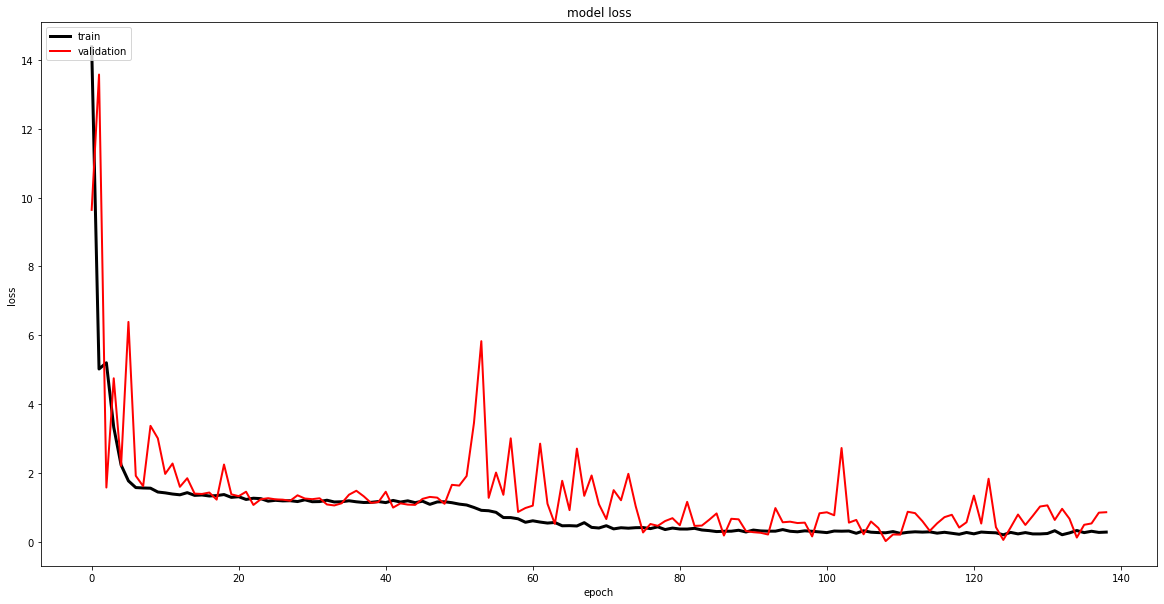

In [0]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], color='black',linewidth=3.0)
plt.plot(history.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From losses curve, it can be visualised that data is not overfitting as both train and validation loss are trends down closely and the losses go lower with increasing number of epochs.

##Performance Evaluation

To evaluate the performance of designed classification model various evaluation metrics are applied. To start with evaluation, Initially load the saved model.

In [0]:
from keras.models import  load_model
model = load_model('./drive/My Drive/best_model.h5')
adam = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999, epsilon=1e-06, decay=0.0
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 64)       

###Prediction Accuracy

Evaluating model prediction accuracy over training set and testing set of image data

In [0]:
train_pred = model.evaluate_generator(trainGenerator,verbose=1)
print("Training Categorical Accuracy :"+str(train_pred[1])+"Training loss : "+str(train_pred[0]))

Training Categorical Accuracy :0.8954593539237976Training loss : 0.2744772136211395


In [0]:
test_pred = model.evaluate_generator(test_gen,verbose=1)
print("Testing Categorical Accuracy :"+str(test_pred[1])+"Testing loss : "+str(test_pred[0]))

Testing Categorical Accuracy :0.9146005511283875Testing loss : 3.965310573577881


Generating array of prediction result of test set image data. To determine the predicted class of image, resulting prediction probablities corresponding to each class for an image is round of to 0 or 1.

In [0]:
testin_predictions = model.predict(test_gen,verbose=1)
testin_predictions[0]

array([0.2610521, 0.1098785, 0.013522 , 0.6155475], dtype=float32)

In [0]:
testin_predictionsb = (testin_predictions>0.5)
testin_predictionsb[0]

array([False, False, False,  True])

### Storing the predictions into a dataframe.

The predicted results will be stored in a dataframe and later will be used to compare with the test_df that contains the actual results for verification and evaluation.

In [0]:
predictions = testin_predictionsb.astype(int)
columns = ['healthy', 'multiple_diseases', 'rust', 'scab']

results = pd.DataFrame(predictions, columns=columns)
results.head()

healthy  multiple_diseases  rust  scab
0        0                  0     0     1
1        0                  0     0     1
2        0                  0     0     1
3        0                  0     0     1
4        0                  0     0     1

In [0]:
results['image_id'] = test_gen.filenames
ordered_cols = ['image_id'] + columns
results = results[ordered_cols]
results.loc[results['healthy']==1]

image_id  healthy  multiple_diseases  rust  scab
12    Train_381.jpg        1                  0     0     0
63   Train_1027.jpg        1                  0     0     0
242   Train_219.jpg        1                  0     0     0
244  Train_1261.jpg        1                  0     0     0
246  Train_1131.jpg        1                  0     0     0
..              ...      ...                ...   ...   ...
341   Train_781.jpg        1                  0     0     0
342   Train_257.jpg        1                  0     0     0
343  Train_1614.jpg        1                  0     0     0
344   Train_685.jpg        1                  0     0     0
346   Train_245.jpg        1                  0     0     0

[99 rows x 5 columns]

In [0]:
test_df.loc[test_df['healthy']==1]

image_id healthy multiple_diseases rust scab
219    Train_219.jpg       1                 0    0    0
1366  Train_1366.jpg       1                 0    0    0
1261  Train_1261.jpg       1                 0    0    0
1583  Train_1583.jpg       1                 0    0    0
1131  Train_1131.jpg       1                 0    0    0
...              ...     ...               ...  ...  ...
1141  Train_1141.jpg       1                 0    0    0
781    Train_781.jpg       1                 0    0    0
257    Train_257.jpg       1                 0    0    0
1614  Train_1614.jpg       1                 0    0    0
685    Train_685.jpg       1                 0    0    0

[103 rows x 5 columns]

Below code block adds new column **'type'** to the predicted results data frame and which holds values of predicted class of the test image. Similar steps are performed on true test data frame for evaluation purpose.

In [0]:
results['image_id'] = test_gen.filenames
results.insert(5,'type', '', False)
ordered_cols = ['image_id'] + columns + ['type']
results = results[ordered_cols]

for i in range(len(results)):
  if results.at[i,'healthy'] == 1:
    results.at[i,'type'] = 'healthy'
  elif results.at[i,'multiple_diseases'] == 1:
    results.at[i,'type'] = 'multiple_diseases'
  elif results.at[i,'rust'] == 1:
    results.at[i,'type'] = 'rust'
  else:
    results.at[i,'type'] = 'scab'

results.head()

image_id  healthy  multiple_diseases  rust  scab  type
0  Train_1816.jpg        0                  0     0     1  scab
1    Train_16.jpg        0                  0     0     1  scab
2   Train_101.jpg        0                  0     0     1  scab
3   Train_540.jpg        0                  0     0     1  scab
4  Train_1140.jpg        0                  0     0     1  scab

In [0]:
true_test = pd.DataFrame(test_df)
true_test = true_test.reset_index(drop=True)
true_test.insert(5,'type','',False)

for i in range(len(true_test)):
  if true_test.at[i,'healthy'] == 1:
    true_test.at[i,'type'] = 'healthy'
  elif true_test.at[i,'multiple_diseases'] == 1:
    true_test.at[i,'type'] = 'multiple_diseases'
  elif true_test.at[i,'rust'] == 1:
    true_test.at[i,'type'] = 'rust'
  else:
    true_test.at[i,'type'] = 'scab'

true_test.head()

image_id healthy multiple_diseases rust scab  type
0  Train_1816.jpg       0                 0    0    1  scab
1    Train_16.jpg       0                 0    0    1  scab
2   Train_101.jpg       0                 0    0    1  scab
3   Train_540.jpg       0                 0    0    1  scab
4  Train_1140.jpg       0                 0    0    1  scab

###Matthews Correlation Coefficient

In [0]:
mcc = metrics.matthews_corrcoef(true_test['type'], results['type'])
print("Matthews Correlation Coefficient: ", mcc)

Matthews Correlation Coefficient:  0.8772163519966899


###Classification Metrics
1. Precision
2. Recall
3. f1-score


In [0]:
classification_matrics = metrics.classification_report(
    true_test['type'], results['type'], colnames
)
print(classification_matrics)


                   precision    recall  f1-score   support

          healthy       0.97      0.93      0.95       103
multiple_diseases       0.25      0.11      0.15        18
             rust       0.96      0.96      0.96       124
             scab       0.87      0.97      0.92       118

         accuracy                           0.91       363
        macro avg       0.76      0.74      0.75       363
     weighted avg       0.90      0.91      0.90       363



###Confusion Matrix

In [0]:
confusion_mtx = metrics.confusion_matrix(y_true = true_test['type'], y_pred = results['type'])
confusion_mtx

array([[ 96,   0,   0,   7],
       [  1,   2,   5,  10],
       [  0,   5, 119,   0],
       [  2,   1,   0, 115]])

In [0]:
def plot_confusion_matrix(cm, classes,
   normalize=True,
   title= 'Confusion matrix',
   cmap=plt.cm.Blues):
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=90)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

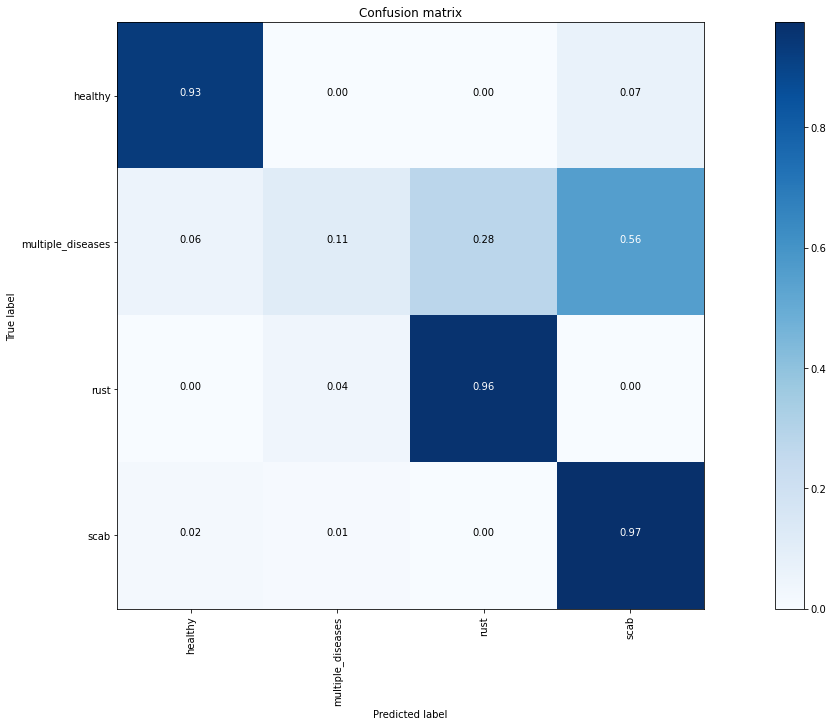

In [0]:
plt.figure(figsize=(20,10))
plot_confusion_matrix(confusion_mtx, colnames)

###Verifying Predictions

1. Here the predicted values will be compared to the actual results and the actual image will be plotted along with the predicted values in bar plot.

2. The correct predictions will be in blue bar plots and the wrong predicitons in red bar plots.


In [0]:
#Getting random images of the different classes from the test set

lst_plot = {}

cols = list(test_df.columns)[1:]

for classes in cols:
  lst_imgs = list(test_df.loc[test_df[classes]==1]['image_id'])
  rnd_sample_img = random.sample(lst_imgs,3)
  lst_plot.update({classes : rnd_sample_img})

lst_plot

{'healthy': ['Train_136.jpg', 'Train_1513.jpg', 'Train_1612.jpg'],
 'multiple_diseases': ['Train_395.jpg', 'Train_1234.jpg', 'Train_62.jpg'],
 'rust': ['Train_735.jpg', 'Train_900.jpg', 'Train_1649.jpg'],
 'scab': ['Train_820.jpg', 'Train_1143.jpg', 'Train_51.jpg']}

In [0]:
predictns = testin_predictions.astype(float)
predictns_results = pd.DataFrame(predictns, columns=columns)
predictns_results['image_id'] = test_gen.filenames
predictns_results.head()

healthy  multiple_diseases          rust      scab        image_id
0  0.261052           0.109878  1.352200e-02  0.615547  Train_1816.jpg
1  0.000501           0.000261  1.157757e-05  0.999226    Train_16.jpg
2  0.000166           0.000730  1.222978e-05  0.999092   Train_101.jpg
3  0.000195           0.000124  1.209732e-06  0.999680   Train_540.jpg
4  0.000003           0.000024  1.200153e-07  0.999973  Train_1140.jpg

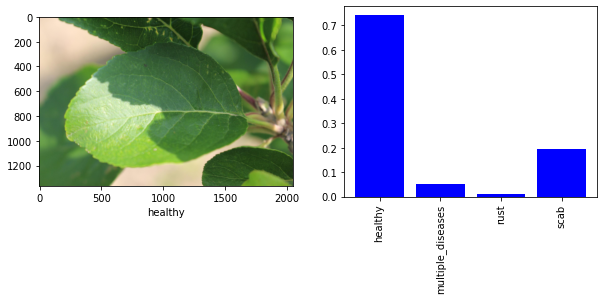

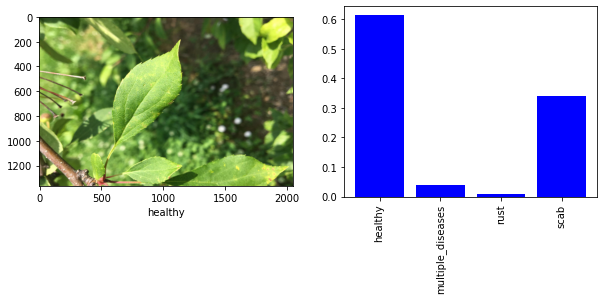

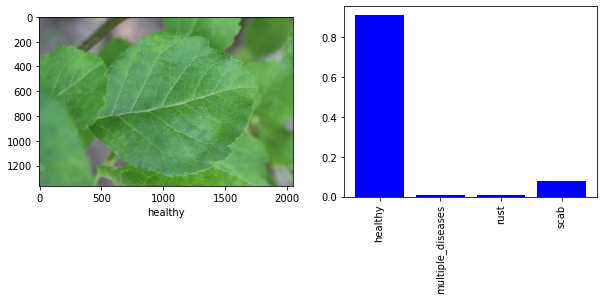

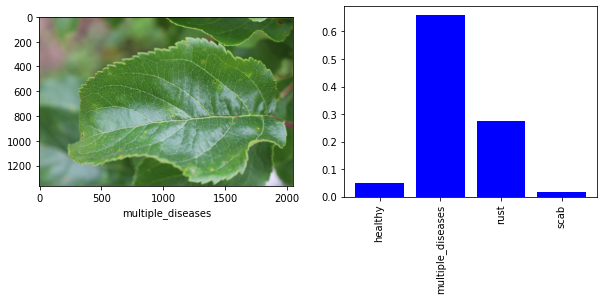

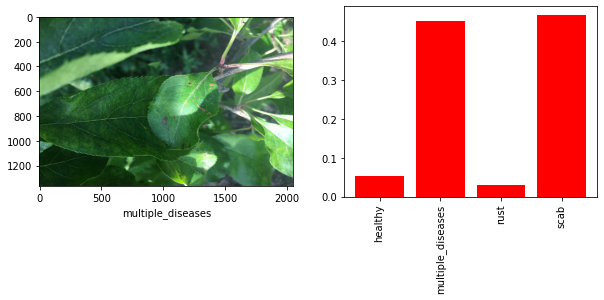

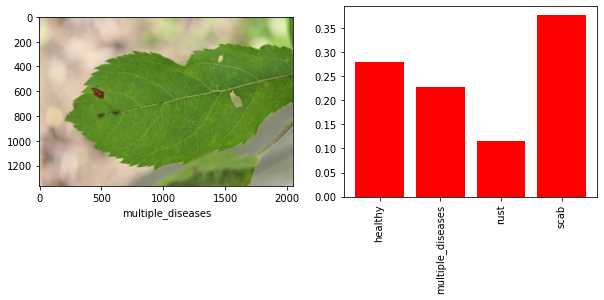

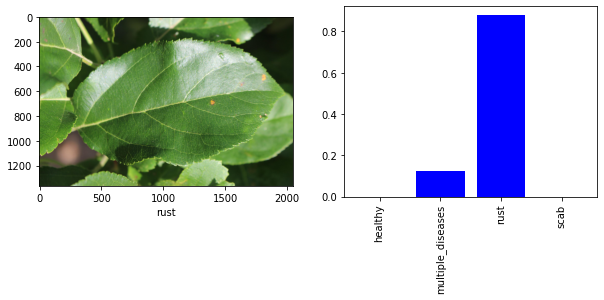

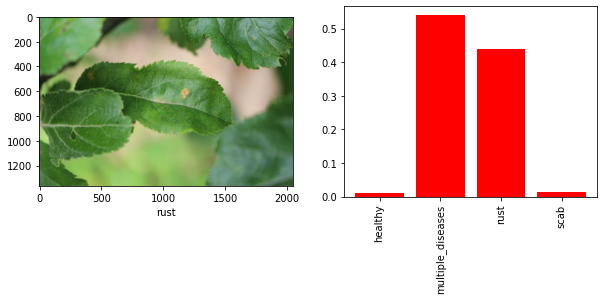

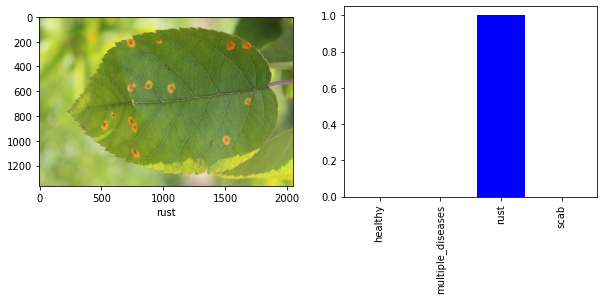

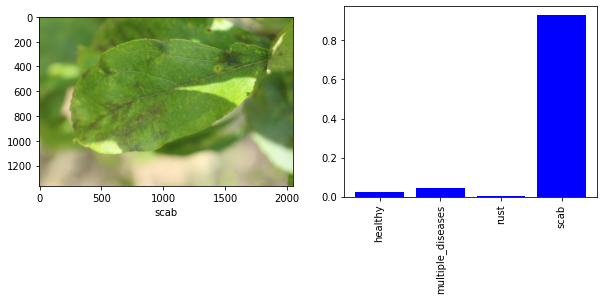

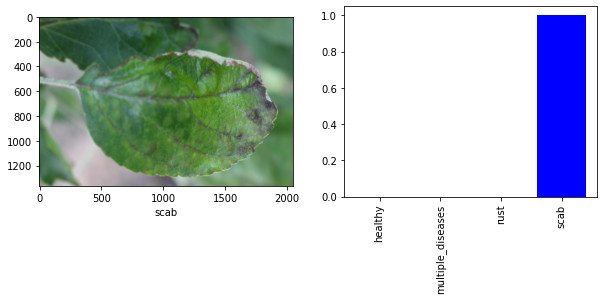

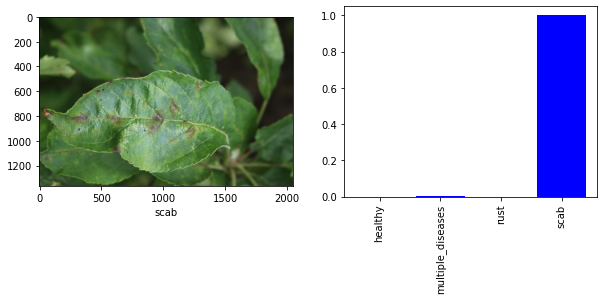

In [0]:
for i in list(lst_plot.keys()):
  for j in lst_plot[i]:
    plt.figure(figsize=(10,3.5))
    plt.subplot(1,2,1)
    infor = predictns_results.loc[predictns_results['image_id']==j]
    im = cv2.imread('Test/'+j)
    #im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.xlabel(list(true_test.loc[true_test['image_id']==j].type)[0])
    plt.subplot(1,2,2)
    labels = cols
    probs = [float(infor.healthy),float(infor.multiple_diseases),float(infor.rust),float(infor.scab)]
    if list(true_test.loc[true_test['image_id']==j].type)[0] == list(results.loc[results['image_id']==j].type)[0]:
      plt.bar(labels,probs,color=['blue'])
    else:
      plt.bar(labels,probs,color=['red'])
    plt.xticks(rotation=90)
    plt.show()

# **Thank You**

---


